In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
class BPMPredictionPipeline:
    """
    Complete pipeline for BeatsPerMinute prediction including EDA and modeling
    """
    
    def __init__(self, data, target_col='BeatsPerMinute', test_size=0.2, random_state=42):
        """
        Initialize the pipeline
        
        Parameters:
        -----------
        data : pd.DataFrame
            Input dataframe with all features and target
        target_col : str
            Name of target column
        test_size : float
            Proportion of data for testing
        random_state : int
            Random seed for reproducibility
        """
        self.data = data.copy()
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.feature_cols = [col for col in data.columns if col != target_col]
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = None
        
    def perform_eda(self, save_plots=True):
        """
        Comprehensive Exploratory Data Analysis
        """
        print("="*80)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*80)
        
        # 1. Basic Information
        print("\n1. DATASET INFORMATION")
        print("-"*40)
        print(f"Shape: {self.data.shape}")
        print(f"Features: {len(self.feature_cols)}")
        print(f"Target: {self.target_col}")
        
        # 2. Data Types and Missing Values
        print("\n2. DATA TYPES AND MISSING VALUES")
        print("-"*40)
        info_df = pd.DataFrame({
            'Data Type': self.data.dtypes,
            'Missing Values': self.data.isnull().sum(),
            'Missing %': (self.data.isnull().sum() / len(self.data)) * 100
        })
        print(info_df)
        
        # 3. Statistical Summary
        print("\n3. STATISTICAL SUMMARY")
        print("-"*40)
        print(self.data.describe().round(2))
        
        # 4. Target Variable Analysis
        print(f"\n4. TARGET VARIABLE ANALYSIS: {self.target_col}")
        print("-"*40)
        target_stats = {
            'Mean': self.data[self.target_col].mean(),
            'Median': self.data[self.target_col].median(),
            'Std': self.data[self.target_col].std(),
            'Skewness': skew(self.data[self.target_col]),
            'Kurtosis': kurtosis(self.data[self.target_col])
        }
        for key, value in target_stats.items():
            print(f"{key}: {value:.2f}")
        
        # 5. Correlation Analysis
        print("\n5. CORRELATION WITH TARGET")
        print("-"*40)
        correlations = self.data.corr()[self.target_col].sort_values(ascending=False)
        print(correlations.round(3))
        
        # 6. Multicollinearity Check
        print("\n6. VARIANCE INFLATION FACTOR (VIF)")
        print("-"*40)
        X = self.data[self.feature_cols].dropna()
        vif_data = pd.DataFrame()
        vif_data["Feature"] = self.feature_cols
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(self.feature_cols))]
        print(vif_data.sort_values('VIF', ascending=False))
        
        if save_plots: # will take some time because we are fitting a random forest regressor under feature importance
            self._create_eda_plots()
        
        return correlations, vif_data
    
    def _create_eda_plots(self):
        """
        Create comprehensive EDA visualizations
        """
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Target Distribution
        ax1 = plt.subplot(4, 4, 1)
        self.data[self.target_col].hist(bins=30, edgecolor='black', alpha=0.7)
        ax1.set_title(f'{self.target_col} Distribution')
        ax1.set_xlabel('BPM')
        ax1.set_ylabel('Frequency')
        
        # 2. Target Box Plot
        ax2 = plt.subplot(4, 4, 2)
        box_data = ax2.boxplot(self.data[self.target_col].dropna(), vert=True, patch_artist=True)
        box_data['boxes'][0].set_facecolor('lightblue')
        ax2.set_title(f'{self.target_col} Box Plot')
        ax2.set_ylabel('BPM')
        
        # 3. Q-Q Plot for Normality
        ax3 = plt.subplot(4, 4, 3)
        stats.probplot(self.data[self.target_col].dropna(), dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot')
        
        # 4. Correlation Heatmap
        ax4 = plt.subplot(4, 4, 4)
        corr_matrix = self.data.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=ax4, cbar_kws={'shrink': 0.8})
        ax4.set_title('Correlation Heatmap')
        
        # 5-12. Feature vs Target Scatter Plots
        for idx, feature in enumerate(self.feature_cols[:8], 5):
            ax = plt.subplot(4, 4, idx)
            ax.scatter(self.data[feature], self.data[self.target_col], alpha=0.5, s=10)
            ax.set_xlabel(feature)
            ax.set_ylabel(self.target_col)
            ax.set_title(f'{feature} vs {self.target_col}')
            
            # Add trend line
            z = np.polyfit(self.data[feature].dropna(), 
                          self.data.loc[self.data[feature].notna(), self.target_col], 1)
            p = np.poly1d(z)
            ax.plot(self.data[feature].sort_values(), 
                   p(self.data[feature].sort_values()), 
                   "r--", alpha=0.8, linewidth=2)
        
        # 13. Feature Distributions
        ax13 = plt.subplot(4, 4, 13)
        feature_data = self.data[self.feature_cols].values.flatten()
        ax13.hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black', alpha=0.7)
        ax13.set_title('All Features Distribution')
        ax13.set_xlabel('Value')
        ax13.set_ylabel('Frequency')
        
        # 14. Pairplot of Top Correlated Features
        ax14 = plt.subplot(4, 4, 14)
        top_corr_features = self.data.corr()[self.target_col].abs().sort_values(ascending=False)[1:4].index
        if len(top_corr_features) >= 2:
            ax14.scatter(self.data[top_corr_features[0]], self.data[top_corr_features[1]], 
                        c=self.data[self.target_col], cmap='viridis', alpha=0.5)
            ax14.set_xlabel(top_corr_features[0])
            ax14.set_ylabel(top_corr_features[1])
            ax14.set_title('Top 2 Correlated Features')
            plt.colorbar(ax14.collections[0], ax=ax14, label=self.target_col)
        
        # 15. Outlier Detection
        ax15 = plt.subplot(4, 4, 15)
        outlier_counts = []
        for feature in self.feature_cols:
            Q1 = self.data[feature].quantile(0.25)
            Q3 = self.data[feature].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((self.data[feature] < (Q1 - 1.5 * IQR)) | 
                       (self.data[feature] > (Q3 + 1.5 * IQR))).sum()
            outlier_counts.append(outliers)
        
        ax15.bar(range(len(self.feature_cols)), outlier_counts)
        ax15.set_xticks(range(len(self.feature_cols)))
        ax15.set_xticklabels(self.feature_cols, rotation=45, ha='right')
        ax15.set_title('Outliers per Feature')
        ax15.set_ylabel('Count')
        
        # 16. Feature Importance (using Random Forest)
        ax16 = plt.subplot(4, 4, 16)
        rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
        X_temp = self.data[self.feature_cols].fillna(self.data[self.feature_cols].mean())
        y_temp = self.data[self.target_col].fillna(self.data[self.target_col].mean())
        rf_temp.fit(X_temp, y_temp)
        
        importance = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': rf_temp.feature_importances_
        }).sort_values('importance', ascending=True)
        
        ax16.barh(range(len(importance)), importance['importance'])
        ax16.set_yticks(range(len(importance)))
        ax16.set_yticklabels(importance['feature'])
        ax16.set_title('Feature Importance (Random Forest)')
        ax16.set_xlabel('Importance')
        
        plt.tight_layout()
        plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✓ EDA plots saved as 'eda_analysis.png'")
    
    def preprocess_data(self, handle_outliers=True, create_polynomial=False):
        """
        Preprocess the data for modeling
        """
        print("\n" + "="*80)
        print("DATA PREPROCESSING")
        print("="*80)
        
        # Handle missing values
        print("\n1. Handling Missing Values...")
        missing_before = self.data.isnull().sum().sum()
        
        # Fill numeric columns with median
        for col in self.feature_cols:
            if self.data[col].dtype in ['float64', 'int64']:
                self.data[col].fillna(self.data[col].median(), inplace=True)
        
        # fill in the target_col with the median
        self.data[self.target_col].fillna(self.data[self.target_col].median(), inplace=True)
        missing_after = self.data.isnull().sum().sum()
        print(f"   Missing values before: {missing_before}")
        print(f"   Missing values after: {missing_after}")
        
        # Handle outliers
        if handle_outliers:
            print("\n2. Handling Outliers (Capping at 1st and 99th percentile)...")
            outliers_handled = 0
            for col in self.feature_cols + [self.target_col]:
                lower = self.data[col].quantile(0.01)
                upper = self.data[col].quantile(0.99)
                before = ((self.data[col] < lower) | (self.data[col] > upper)).sum()
                self.data[col] = self.data[col].clip(lower=lower, upper=upper)
                outliers_handled += before
            print(f"   Total outliers capped: {outliers_handled}")
        
        # Feature Engineering
        print("\n3. Feature Engineering...")
        
        # Create ratio features
        if 'Energy' in self.feature_cols and 'TrackDurationMs' in self.feature_cols:
            self.data['Energy_per_Second'] = self.data['Energy'] / (self.data['TrackDurationMs'] / 1000)
            self.feature_cols.append('Energy_per_Second')
            print("   ✓ Created Energy_per_Second feature")
        
        if 'VocalContent' in self.feature_cols and 'InstrumentalScore' in self.feature_cols:
            self.data['Vocal_Instrumental_Ratio'] = self.data['VocalContent'] / (self.data['InstrumentalScore'] + 0.01)
            self.feature_cols.append('Vocal_Instrumental_Ratio')
            print("   ✓ Created Vocal_Instrumental_Ratio feature")
        
        # Create polynomial features for top correlated variables
        if create_polynomial:
            print("   Creating polynomial features...")
            top_features = self.data.corr()[self.target_col].abs().sort_values(ascending=False)[1:3].index.tolist()
            poly = PolynomialFeatures(degree=2, include_bias=False)
            poly_features = poly.fit_transform(self.data[top_features])
            poly_df = pd.DataFrame(poly_features, 
                                 columns=poly.get_feature_names_out(top_features),
                                 index=self.data.index)
            
            # Add only the interaction and squared terms
            new_cols = [col for col in poly_df.columns if col not in top_features]
            self.data = pd.concat([self.data, poly_df[new_cols]], axis=1)
            self.feature_cols.extend(new_cols)
            print(f"   ✓ Added {len(new_cols)} polynomial features")
        
        print(f"\n✓ Final dataset shape: {self.data.shape}")
        print(f"✓ Total features: {len(self.feature_cols)}")
    
    def split_and_scale(self):
        """
        Split data and apply scaling
        """
        print("\n" + "="*80)
        print("DATA SPLITTING AND SCALING")
        print("="*80)
        
        # Split features and target
        X = self.data[self.feature_cols]
        y = self.data[self.target_col]
        
        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")
        
        # Scale features
        self.scaler = RobustScaler()  # Robust to outliers
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Create DataFrame versions for easier handling
        self.X_train_scaled_df = pd.DataFrame(
            self.X_train_scaled, 
            columns=self.feature_cols, 
            index=self.X_train.index
        )
        self.X_test_scaled_df = pd.DataFrame(
            self.X_test_scaled, 
            columns=self.feature_cols, 
            index=self.X_test.index
        )
        
        print("✓ Data split and scaling completed")
    
    def train_baseline_model(self):
        """
        Train a simple linear regression as baseline
        """
        print("\n" + "="*80)
        print("BASELINE MODEL (Linear Regression)")
        print("="*80)
        
        lr = LinearRegression()
        lr.fit(self.X_train_scaled, self.y_train)
        y_pred = lr.predict(self.X_test_scaled)
        
        baseline_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        baseline_mae = mean_absolute_error(self.y_test, y_pred)
        baseline_r2 = r2_score(self.y_test, y_pred)
        
        self.baseline_rmse = baseline_rmse
        
        print(f"Baseline RMSE: {baseline_rmse:.4f}")
        print(f"Baseline MAE: {baseline_mae:.4f}")
        print(f"Baseline R²: {baseline_r2:.4f}")
        
        return baseline_rmse
    
    def train_models(self, use_cv=True, n_folds=5):
        """
        Train all recommended models
        """
        print("\n" + "="*80)
        print("MODEL TRAINING AND EVALUATION")
        print("="*80)
        
        # Define models with optimized hyperparameters
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state,
                n_jobs=-1
            ),
            'XGBoost': xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=self.random_state,
                n_jobs=-1
            ),
            'LightGBM': lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                random_state=self.random_state,
                n_jobs=-1,
                verbose=-1
            ),
            # 'SVR': SVR( # can consider changing to SGDRegressor for faster training 
            #     kernel='rbf',
            #     C=10,
            #     epsilon=0.1,
            #     gamma='scale'
            # ),
            'Elastic Net': ElasticNet(
                alpha=0.1,
                l1_ratio=0.5,
                random_state=self.random_state,
                max_iter=1000
            ),
            'Neural Network': MLPRegressor(
                hidden_layer_sizes=(100, 50),
                activation='relu',
                solver='adam',
                learning_rate='adaptive',
                max_iter=500,
                random_state=self.random_state,
                early_stopping=True,
                validation_fraction=0.1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=150,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                random_state=self.random_state
            )
        }
        
        # Train and evaluate each model
        results = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Determine if scaling is needed
            if name in ['SVR', 'Neural Network', 'Elastic Net']:
                X_train = self.X_train_scaled
                X_test = self.X_test_scaled
            else:
                X_train = self.X_train
                X_test = self.X_test
            
            # Train model
            model.fit(X_train, self.y_train)
            
            # Make predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate metrics
            train_rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
            test_mae = mean_absolute_error(self.y_test, y_pred_test)
            test_r2 = r2_score(self.y_test, y_pred_test)
            test_mape = mean_absolute_percentage_error(self.y_test, y_pred_test)
            
            # Cross-validation
            if use_cv:
                cv_scores = cross_val_score(
                    model, X_train, self.y_train, 
                    cv=n_folds, 
                    # use negative here because we are trying to maximize performance
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1
                )
                cv_rmse = -cv_scores.mean()
                cv_std = cv_scores.std()
            else:
                cv_rmse = cv_std = None
            
            # Store results
            results[name] = {
                'model': model,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'test_r2': test_r2,
                'test_mape': test_mape,
                'cv_rmse': cv_rmse,
                'cv_std': cv_std,
                'predictions': y_pred_test
            }
            
            print(f"  Train RMSE: {train_rmse:.4f}")
            print(f"  Test RMSE: {test_rmse:.4f}")
            print(f"  Test MAE: {test_mae:.4f}")
            print(f"  Test R²: {test_r2:.4f}")
            print(f"  Test MAPE: {test_mape:.4%}")
            if use_cv:
                print(f"  CV RMSE: {cv_rmse:.4f} (+/- {cv_std:.4f})")
        
        self.models = models
        self.results = results
        
        # Find best model
        best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
        self.best_model = results[best_model_name]['model']
        self.best_model_name = best_model_name
        
        print("\n" + "="*80)
        print(f"BEST MODEL: {best_model_name}")
        print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
        print(f"Improvement over baseline: {(self.baseline_rmse - results[best_model_name]['test_rmse']) / self.baseline_rmse * 100:.2f}%")
        
        return results
    
    def hyperparameter_tuning(self, model_name='XGBoost', cv_folds=3):
        """
        Perform hyperparameter tuning for a specific model
        """
        print("\n" + "="*80)
        print(f"HYPERPARAMETER TUNING: {model_name}")
        print("="*80)
        
        param_grids = {
            'XGBoost': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 5, 7],
                'subsample': [0.7, 0.8, 0.9]
            },
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'LightGBM': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'num_leaves': [31, 50, 70],
                'max_depth': [5, 7, 10]
            },
            'SVR': {
                'C': [0.1, 1, 10, 100],
                'epsilon': [0.001, 0.01, 0.1, 0.5],
                'gamma': ['scale', 'auto', 0.001, 0.01]
            },
            'Elastic Net': {
                'alpha': [0.001, 0.01, 0.1, 1.0],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        }
        
        if model_name not in param_grids:
            print(f"No parameter grid defined for {model_name}")
            return
        
        # Select appropriate data
        if model_name in ['SVR', 'Elastic Net']:
            X_train = self.X_train_scaled
        else:
            X_train = self.X_train
        
        # Create base model
        if model_name == 'XGBoost':
            base_model = xgb.XGBRegressor(random_state=self.random_state, n_jobs=-1)
        elif model_name == 'Random Forest':
            base_model = RandomForestRegressor(random_state=self.random_state, n_jobs=-1)
        elif model_name == 'LightGBM':
            base_model = lgb.LGBMRegressor(random_state=self.random_state, n_jobs=-1, verbose=-1)
        elif model_name == 'SVR':
            base_model = SVR()
        elif model_name == 'Elastic Net':
            base_model = ElasticNet(random_state=self.random_state)
        
        # Grid search
        grid_search = GridSearchCV(
            base_model,
            param_grids[model_name],
            cv=cv_folds,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        print(f"Searching {len(param_grids[model_name])} parameter combinations...")
        grid_search.fit(X_train, self.y_train)
        
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
        
        # Evaluate on test set
        if model_name in ['SVR', 'Elastic Net']:
            X_test = self.X_test_scaled
        else:
            X_test = self.X_test
        
        y_pred = grid_search.best_estimator_.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        
        print(f"Test RMSE with best parameters: {test_rmse:.4f}")
        
        return grid_search.best_estimator_, grid_search.best_params_
    
    def create_ensemble(self):
        """
        Create an ensemble of best performing models
        """
        print("\n" + "="*80)
        print("ENSEMBLE MODEL CREATION")
        print("="*80)
        
        # Select top 3 models based on test RMSE
        sorted_models = sorted(self.results.items(), key=lambda x: x[1]['test_rmse'])[:3]
        
        print("Top 3 models for ensemble:")
        for name, metrics in sorted_models:
            print(f"  - {name}: RMSE = {metrics['test_rmse']:.4f}")
        
        # Create voting regressor
        estimators = []
        for name, metrics in sorted_models:
            if name in ['SVR', 'Neural Network', 'Elastic Net']:
                # These models need scaled data, we'll handle this separately
                continue
            estimators.append((name, metrics['model']))
        
        if estimators:
            ensemble = VotingRegressor(estimators=estimators)
            ensemble.fit(self.X_train, self.y_train)
            
            # Predictions
            y_pred_ensemble = ensemble.predict(self.X_test)
            ensemble_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_ensemble))
            ensemble_r2 = r2_score(self.y_test, y_pred_ensemble)
            
            print(f"\nEnsemble Model Performance:")
            print(f"  RMSE: {ensemble_rmse:.4f}")
            print(f"  R²: {ensemble_r2:.4f}")
                        
            # Check if ensemble is better
            if ensemble_rmse < self.results[self.best_model_name]['test_rmse']:
                print("✓ Ensemble performs better than individual models!")
                self.best_model = ensemble
                self.best_model_name = 'Ensemble'

                # Add ensemble to results
                self.results['Ensemble'] = {
                    'model': ensemble,
                    'train_rmse': None,
                    'test_rmse': ensemble_rmse,
                    'test_mae': None,
                    'test_r2': ensemble_r2,
                    'test_mape': None,
                    'cv_rmse': None,
                    'cv_std': None,
                    'predictions': y_pred_ensemble
                }
                
            else:
                print("✗ Individual model performs better than ensemble")
            
            return ensemble
    
    def plot_model_comparison(self):
        """
        Visualize model performance comparison
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. RMSE Comparison
        ax1 = axes[0, 0]
        model_names = list(self.results.keys())
        train_rmse = [self.results[name]['train_rmse'] for name in model_names]
        test_rmse = [self.results[name]['test_rmse'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax1.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
        ax1.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
        ax1.axhline(y=self.baseline_rmse, color='r', linestyle='--', label='Baseline')
        
        ax1.set_xlabel('Model')
        ax1.set_ylabel('RMSE')
        ax1.set_title('Model RMSE Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. R² Score Comparison
        ax2 = axes[0, 1]
        r2_scores = [self.results[name]['test_r2'] for name in model_names]
        bars = ax2.bar(model_names, r2_scores, color='green', alpha=0.7)
        ax2.set_xlabel('Model')
        ax2.set_ylabel('R² Score')
        ax2.set_title('Model R² Score Comparison')
        ax2.set_xticklabels(model_names, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, score in zip(bars, r2_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.3f}', ha='center', va='bottom')
        
        # 3. Cross-validation scores
        ax3 = axes[0, 2]
        cv_rmse = [self.results[name]['cv_rmse'] for name in model_names if self.results[name]['cv_rmse']]
        cv_std = [self.results[name]['cv_std'] for name in model_names if self.results[name]['cv_rmse']]
        cv_names = [name for name in model_names if self.results[name]['cv_rmse']]
        
        if cv_rmse:
            ax3.errorbar(range(len(cv_names)), cv_rmse, yerr=cv_std, 
                        fmt='o-', capsize=5, capthick=2, markersize=8)
            ax3.set_xlabel('Model')
            ax3.set_ylabel('CV RMSE')
            ax3.set_title('Cross-Validation RMSE (with std)')
            ax3.set_xticks(range(len(cv_names)))
            ax3.set_xticklabels(cv_names, rotation=45, ha='right')
            ax3.grid(True, alpha=0.3)
        
        # 4. Actual vs Predicted for Best Model
        ax4 = axes[1, 0]
        best_predictions = self.results[self.best_model_name]['predictions']
        ax4.scatter(self.y_test, best_predictions, alpha=0.5, s=20)
        ax4.plot([self.y_test.min(), self.y_test.max()], 
                [self.y_test.min(), self.y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
        ax4.set_xlabel('Actual BPM')
        ax4.set_ylabel('Predicted BPM')
        ax4.set_title(f'Best Model ({self.best_model_name}): Actual vs Predicted')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Residual Plot for Best Model
        ax5 = axes[1, 1]
        residuals = self.y_test - best_predictions
        ax5.scatter(best_predictions, residuals, alpha=0.5, s=20)
        ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax5.set_xlabel('Predicted BPM')
        ax5.set_ylabel('Residuals')
        ax5.set_title(f'Residual Plot ({self.best_model_name})')
        ax5.grid(True, alpha=0.3)
        
        # Add confidence bands
        residual_std = np.std(residuals)
        ax5.axhline(y=residual_std*2, color='orange', linestyle=':', alpha=0.7, label='±2σ')
        ax5.axhline(y=-residual_std*2, color='orange', linestyle=':', alpha=0.7)
        ax5.legend()
        
        # 6. Learning Curves
        ax6 = axes[1, 2]
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_scores = []
        val_scores = []
        
        for train_size in train_sizes:
            # Use a subset of data
            n_samples = int(train_size * len(self.X_train))
            if n_samples < 10:
                continue
                
            X_subset = self.X_train[:n_samples]
            y_subset = self.y_train[:n_samples]
            
            # Train a simple model for learning curve
            simple_model = RandomForestRegressor(n_estimators=50, random_state=42)
            simple_model.fit(X_subset, y_subset)
            
            train_pred = simple_model.predict(X_subset)
            val_pred = simple_model.predict(self.X_test)
            
            train_scores.append(np.sqrt(mean_squared_error(y_subset, train_pred)))
            val_scores.append(np.sqrt(mean_squared_error(self.y_test, val_pred)))
        
        actual_sizes = [int(train_size * len(self.X_train)) for train_size in train_sizes if int(train_size * len(self.X_train)) >= 10]
        ax6.plot(actual_sizes, train_scores, 'o-', label='Training Score', linewidth=2)
        ax6.plot(actual_sizes, val_scores, 'o-', label='Validation Score', linewidth=2)
        ax6.set_xlabel('Training Set Size')
        ax6.set_ylabel('RMSE')
        ax6.set_title('Learning Curves')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Model comparison plots saved as 'model_comparison.png'")
    
    def feature_importance_analysis(self):
        """
        Analyze feature importance across different models
        """
        print("\n" + "="*80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*80)
        
        importance_dict = {}
        
        # Get feature importance from tree-based models
        tree_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
        
        for model_name in tree_models:
            if model_name in self.results:
                model = self.results[model_name]['model']
                if hasattr(model, 'feature_importances_'):
                    importance_dict[model_name] = model.feature_importances_
        
        # Create importance DataFrame
        if importance_dict:
            importance_df = pd.DataFrame(importance_dict, index=self.feature_cols)
            importance_df['Mean'] = importance_df.mean(axis=1)
            importance_df = importance_df.sort_values('Mean', ascending=False)
            
            print("\nTop 10 Most Important Features (Average across tree models):")
            print(importance_df['Mean'].head(10).round(4))
            
            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Bar plot of mean importance
            ax1 = axes[0]
            top_features = importance_df.nlargest(15, 'Mean')
            ax1.barh(range(len(top_features)), top_features['Mean'])
            ax1.set_yticks(range(len(top_features)))
            ax1.set_yticklabels(top_features.index)
            ax1.set_xlabel('Mean Importance')
            ax1.set_title('Top 15 Features by Mean Importance')
            ax1.grid(True, alpha=0.3)
            
            # Heatmap of importance across models
            ax2 = axes[1]
            sns.heatmap(importance_df.drop('Mean', axis=1).head(15).T, 
                       annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
            ax2.set_title('Feature Importance Across Models')
            ax2.set_xlabel('Features')
            ax2.set_ylabel('Models')
            
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✓ Feature importance plots saved as 'feature_importance.png'")
            
            return importance_df
        
        return None
    
    def generate_report(self):
        """
        Generate comprehensive model performance report
        """
        print("\n" + "="*80)
        print("FINAL PERFORMANCE REPORT")
        print("="*80)
        
        # Create summary DataFrame
        summary_data = []
        for model_name, metrics in self.results.items():
            summary_data.append({
                'Model': model_name,
                'Train RMSE': f"{metrics['train_rmse']:.4f}",
                'Test RMSE': f"{metrics['test_rmse']:.4f}",
                'Test MAE': f"{metrics['test_mae']:.4f}",
                'Test R²': f"{metrics['test_r2']:.4f}",
                'Test MAPE': f"{metrics['test_mape']:.2%}",
                'CV RMSE': f"{metrics['cv_rmse']:.4f}" if metrics['cv_rmse'] else 'N/A',
                'Improvement vs Baseline': f"{((self.baseline_rmse - metrics['test_rmse'])/self.baseline_rmse)*100:.2f}%"
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Test RMSE')
        
        print("\nMODEL PERFORMANCE SUMMARY:")
        print(summary_df.to_string(index=False))
        
        print(f"\n" + "="*80)
        print(f"WINNER: {self.best_model_name}")
        print(f"Test RMSE: {self.results[self.best_model_name]['test_rmse']:.4f}")
        print(f"This is {((self.baseline_rmse - self.results[self.best_model_name]['test_rmse'])/self.baseline_rmse)*100:.2f}% better than the baseline")
        print("="*80)
        
        # Save report to file
        with open('model_report.txt', 'w') as f:
            f.write("BPM PREDICTION MODEL REPORT\n")
            f.write("="*80 + "\n\n")
            f.write(f"Dataset Shape: {self.data.shape}\n")
            f.write(f"Target Variable: {self.target_col}\n")
            f.write(f"Number of Features: {len(self.feature_cols)}\n")
            f.write(f"Train/Test Split: {(1-self.test_size)*100:.0f}/{self.test_size*100:.0f}\n\n")
            f.write("MODEL PERFORMANCE SUMMARY:\n")
            f.write(summary_df.to_string(index=False))
            f.write(f"\n\nBEST MODEL: {self.best_model_name}\n")
            f.write(f"Test RMSE: {self.results[self.best_model_name]['test_rmse']:.4f}\n")
        
        print("\n✓ Report saved as 'model_report.txt'")
        
        return summary_df
    
    def predict_new_data(self, new_data, model_name= None, params = None):
        """
        Make predictions on new data
        
        Parameters:
        -----------
        new_data : pd.DataFrame
            New data with same features as training data
        
        Returns:
        --------
        predictions : np.array
            Predicted BPM values
        """
        if self.best_model is None:
            raise ValueError("No model has been trained yet. Run train_models() first.")
        
        # Ensure all features are present
        missing_features = set(self.feature_cols) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features in new data: {missing_features}")
        
        # Select and order features
        X_new = new_data[self.feature_cols]
        
        # Scale if necessary
        if self.best_model_name in ['SVR', 'Neural Network', 'Elastic Net']:
            X_new = self.scaler.transform(X_new)
        
        # Make predictions
        predictions = self.best_model.predict(X_new)
        
        return predictions

In [3]:
data = pd.read_csv('playground-series-s5e9/train.csv', index_col = 0)  # Replace with your actual data file

In [4]:
# Initialize pipeline
pipeline = BPMPredictionPipeline(data, target_col='BeatsPerMinute')

In [5]:
# Run complete pipeline
print("\nStarting BPM Prediction Pipeline...")
print("="*80)

# 1. Exploratory Data Analysis
correlations, vif_data = pipeline.perform_eda(save_plots=False)
# will take a long time because under save_plots, we are fitting a randomforest to find the feature importance


Starting BPM Prediction Pipeline...
EXPLORATORY DATA ANALYSIS

1. DATASET INFORMATION
----------------------------------------
Shape: (524164, 10)
Features: 9
Target: BeatsPerMinute

2. DATA TYPES AND MISSING VALUES
----------------------------------------
                          Data Type  Missing Values  Missing %
RhythmScore                 float64               0        0.0
AudioLoudness               float64               0        0.0
VocalContent                float64               0        0.0
AcousticQuality             float64               0        0.0
InstrumentalScore           float64               0        0.0
LivePerformanceLikelihood   float64               0        0.0
MoodScore                   float64               0        0.0
TrackDurationMs             float64               0        0.0
Energy                      float64               0        0.0
BeatsPerMinute              float64               0        0.0

3. STATISTICAL SUMMARY
-------------------------

In [6]:
# 2. Data Preprocessing
pipeline.preprocess_data(handle_outliers=True, create_polynomial=False)


DATA PREPROCESSING

1. Handling Missing Values...
   Missing values before: 0
   Missing values after: 0

2. Handling Outliers (Capping at 1st and 99th percentile)...
   Total outliers capped: 57540

3. Feature Engineering...
   ✓ Created Energy_per_Second feature
   ✓ Created Vocal_Instrumental_Ratio feature

✓ Final dataset shape: (524164, 12)
✓ Total features: 11


In [7]:
# 3. Split and Scale Data
pipeline.split_and_scale()


DATA SPLITTING AND SCALING
Training set size: (419331, 11)
Test set size: (104833, 11)
✓ Data split and scaling completed


In [8]:
# 4. Train Baseline Model -> need to update to include a CV value as well
baseline_rmse = pipeline.train_baseline_model()


BASELINE MODEL (Linear Regression)
Baseline RMSE: 26.1130
Baseline MAE: 21.0532
Baseline R²: 0.0001


In [9]:
# 5. Train All Models
results = pipeline.train_models(use_cv=True, n_folds=5)


MODEL TRAINING AND EVALUATION

Training Random Forest...
  Train RMSE: 25.3681
  Test RMSE: 26.1170
  Test MAE: 21.0603
  Test R²: -0.0002
  Test MAPE: 19.5661%
  CV RMSE: 26.1359 (+/- 0.0467)

Training XGBoost...
  Train RMSE: 25.9137
  Test RMSE: 26.1189
  Test MAE: 21.0612
  Test R²: -0.0004
  Test MAPE: 19.5664%
  CV RMSE: 26.1437 (+/- 0.0461)

Training LightGBM...
  Train RMSE: 26.0037
  Test RMSE: 26.1132
  Test MAE: 21.0554
  Test R²: 0.0001
  Test MAPE: 19.5623%
  CV RMSE: 26.1344 (+/- 0.0464)

Training Elastic Net...
  Train RMSE: 26.1319
  Test RMSE: 26.1132
  Test MAE: 21.0542
  Test R²: 0.0001
  Test MAPE: 19.5642%
  CV RMSE: 26.1322 (+/- 0.0450)

Training Neural Network...
  Train RMSE: 26.1304
  Test RMSE: 26.1302
  Test MAE: 21.0696
  Test R²: -0.0012
  Test MAPE: 19.6349%
  CV RMSE: 26.1491 (+/- 0.0447)

Training Gradient Boosting...
  Train RMSE: 26.0312
  Test RMSE: 26.1109
  Test MAE: 21.0531
  Test R²: 0.0002
  Test MAPE: 19.5611%
  CV RMSE: 26.1305 (+/- 0.0458)

B

In [14]:
pipeline.results['Random Forest']['model']  # Example of accessing model parameters

,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# 6. Hyperparameter Tuning for Best Model
if pipeline.best_model_name in ['XGBoost', 'Random Forest', 'LightGBM', 'SVR', 'Elastic Net']:
    tuned_model, best_params = pipeline.hyperparameter_tuning(
        model_name=pipeline.best_model_name, 
        cv_folds=5
    )

In [15]:
# # 6. Hyperparameter Tuning for Best Model
# if pipeline.best_model_name in ['XGBoost', 'Random Forest', 'LightGBM', 'SVR', 'Elastic Net']:
tuned_model, best_params = pipeline.hyperparameter_tuning(
    model_name='LightGBM', 
        cv_folds=5)



HYPERPARAMETER TUNING: LightGBM
Searching 4 parameter combinations...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Best CV RMSE: 26.1251
Test RMSE with best parameters: 26.1065


In [16]:
# # 6. Hyperparameter Tuning for Best Model
# if pipeline.best_model_name in ['XGBoost', 'Random Forest', 'LightGBM', 'SVR', 'Elastic Net']:
tuned_model, best_params = pipeline.hyperparameter_tuning(
    model_name='XGBoost', 
        cv_folds=5)



HYPERPARAMETER TUNING: XGBoost
Searching 4 parameter combinations...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 26.1258
Test RMSE with best parameters: 26.1089


In [17]:
# # 6. Hyperparameter Tuning for Best Model
# if pipeline.best_model_name in ['XGBoost', 'Random Forest', 'LightGBM', 'SVR', 'Elastic Net']:
tuned_model, best_params = pipeline.hyperparameter_tuning(
    model_name='Elastic Net', 
        cv_folds=5)



HYPERPARAMETER TUNING: Elastic Net
Searching 2 parameter combinations...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best CV RMSE: 26.1315
Test RMSE with best parameters: 26.1129


In [18]:
# 7. Create Ensemble
ensemble = pipeline.create_ensemble()



ENSEMBLE MODEL CREATION
Top 3 models for ensemble:
  - Gradient Boosting: RMSE = 26.1109
  - LightGBM: RMSE = 26.1132
  - Elastic Net: RMSE = 26.1132

Ensemble Model Performance:
  RMSE: 26.1100
  R²: 0.0003
✓ Ensemble performs better than individual models!



FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features (Average across tree models):
RhythmScore                  172.0771
MoodScore                    150.5745
TrackDurationMs              149.5851
Energy                       142.8145
Energy_per_Second            141.3218
LivePerformanceLikelihood    140.8156
AudioLoudness                138.5685
AcousticQuality              134.8176
Vocal_Instrumental_Ratio     120.5653
VocalContent                 116.8115
Name: Mean, dtype: float64


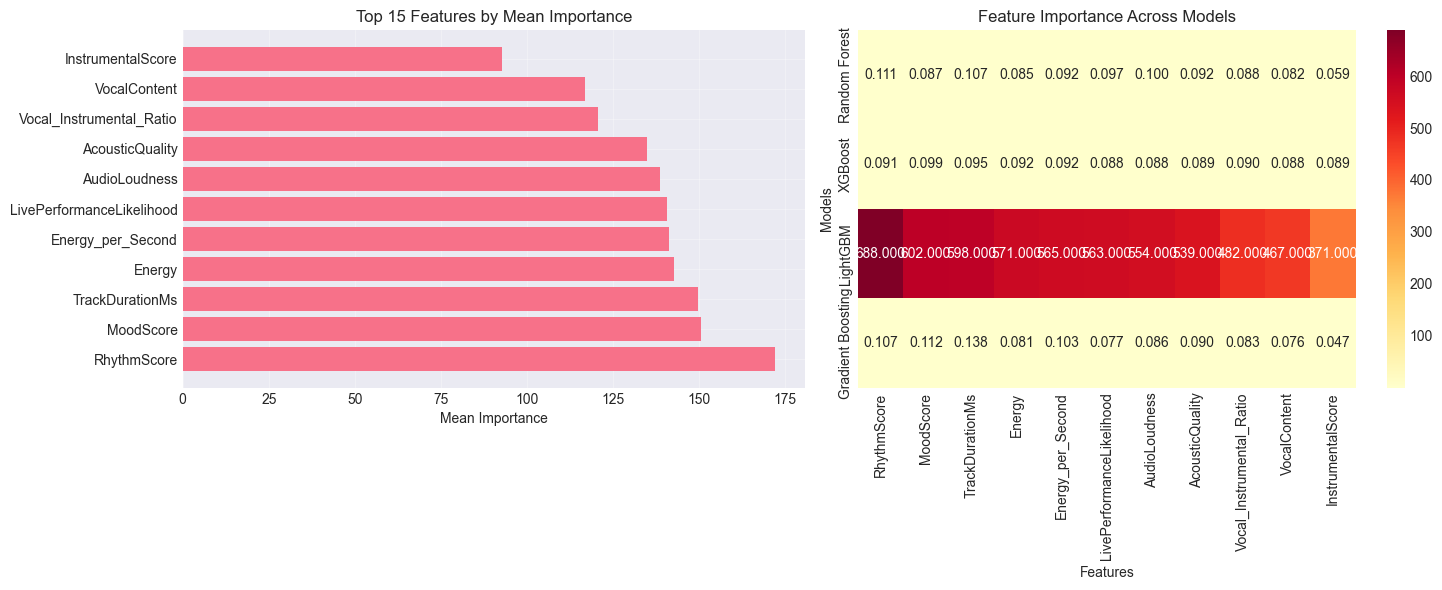


✓ Feature importance plots saved as 'feature_importance.png'


In [19]:
# 8. Feature Importance Analysis
importance_df = pipeline.feature_importance_analysis()


In [21]:
ensemble

,estimators,"[('Gradient Boosting', ...), ('LightGBM', ...)]"
,weights,None
,n_jobs,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.05
,n_estimators,150
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1


KeyError: 'Ensemble'

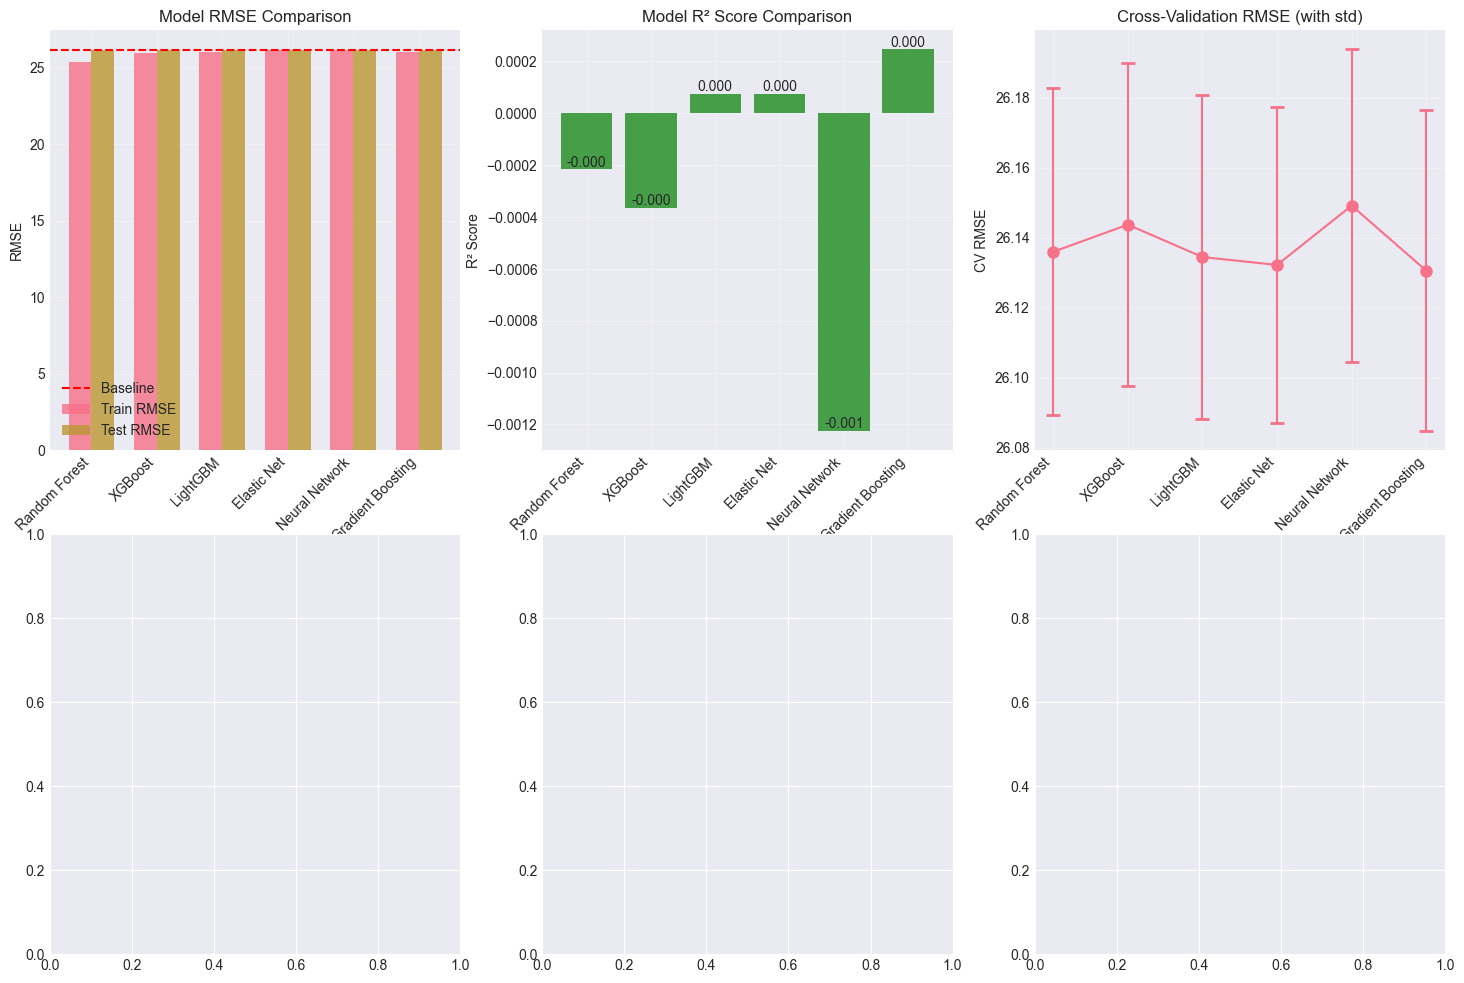

In [20]:
# 9. Plot Model Comparisons
pipeline.plot_model_comparison()


In [ ]:
# 10. Generate Final Report
summary_df = pipeline.generate_report()

print("\n" + "="*80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated files:")
print("  - eda_analysis.png: Comprehensive EDA visualizations")
print("  - model_comparison.png: Model performance comparisons")
print("  - feature_importance.png: Feature importance analysis")
print("  - model_report.txt: Detailed performance report")

In [ ]:
pipeline.models['Elastic Net'].predict()

In [ ]:
# specify that the lightgbm model in the pipeline class to make prediction on new data, ensure that the parameters of the lightgbm model are the same as the tuned parameters
new_data = pd.read_csv('playground-series-s5e9/test.csv', index_col = 0)  # Replace with your actual new data file
predictions = pipeline.predict_new_data(new_data)
print("\nPredictions on new data:")
print(predictions)

In [ ]:
# # Example usage
# if __name__ == "__main__":
#     # Option 1: Use with sample data
#     pipeline = run_complete_pipeline(create_sample_data=True)
    
#     # Option 2: Use with your own data
#     # pipeline = run_complete_pipeline(data_path="your_music_data.csv", create_sample_data=False)
    
#     # Making predictions on new data
#     # new_songs = pd.read_csv("new_songs.csv")
#     # predictions = pipeline.predict_new_data(new_songs)
#     # print(f"Predicted BPM values: {predictions}")

# Modular BPM Prediction Functions
Author: Kevin <br>
Date: 2025

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Data Preprocessing Functions

In [ ]:
# TODO: modify the function to do loading and EDA
# TODO: add a preprocessing function later
def load_and_eda(data_path=None, data=None, target_col='BeatsPerMinute', 
                         handle_outliers=True, create_polynomial=False, feature_engineering=False):
    """
    Load and preprocess data for BPM prediction
    
    Parameters:
    -----------
    data_path : str, optional
        Path to CSV file
    data : pd.DataFrame, optional
        DataFrame if already loaded
    target_col : str
        Name of target column
    handle_outliers : bool
        Whether to handle outliers
    create_polynomial : bool
        Whether to create polynomial features
    
    Returns:
    --------
    dict : Contains processed data and metadata
    """
    print("="*80)
    print("DATA LOADING AND PREPROCESSING")
    print("="*80)
    
    # Load data
    if data is None and data_path is None:
        raise ValueError("Either data_path or data must be provided")
    
    if data is None:
        data = pd.read_csv(data_path, index_col = 0)
        print(f"Data loaded from {data_path}")
    else:
        data = data.copy()
        print("Data provided directly")
    
    print(f"Original shape: {data.shape}")
    
    feature_cols = [col for col in data.columns if col != target_col]
    
    # Handle missing values
    print("\n1. Handling Missing Values...")
    missing_before = data.isnull().sum().sum()
    
    for col in feature_cols:
        if data[col].dtype in ['float64', 'int64']:
            data[col].fillna(data[col].median(), inplace=True)
    
    data[target_col].fillna(data[target_col].median(), inplace=True)
    missing_after = data.isnull().sum().sum()
    print(f"   Missing values before: {missing_before}")
    print(f"   Missing values after: {missing_after}")
    
    # Handle outliers
    # TODO : This handle outlier function is wrong, need to re-do it
    if handle_outliers:
        print("\n2. Handling Outliers (Capping at 1st and 99th percentile)...")
        outliers_handled = 0
        for col in feature_cols + [target_col]:
            lower = data[col].quantile(0.01)
            upper = data[col].quantile(0.99)
            before = ((data[col] < lower) | (data[col] > upper)).sum()
            data[col] = data[col].clip(lower=lower, upper=upper)
            outliers_handled += before
        print(f"   Total outliers capped: {outliers_handled}")

        # remove outliers from the dataset
        data = data[(data[target_col] >= data[target_col].quantile(0.01)) & (data[target_col] <= data[target_col].quantile(0.99))]
        print(f"   Shape after outlier handling: {data.shape}")
    
    if feature_engineering:
        # Feature Engineering
        print("\n3. Feature Engineering...")
        
        if 'Energy' in feature_cols and 'TrackDurationMs' in feature_cols:
            data['Energy_per_Second'] = data['Energy'] / (data['TrackDurationMs'] / 1000)
            feature_cols.append('Energy_per_Second')
            print("   Created Energy_per_Second feature")
        
        if 'VocalContent' in feature_cols and 'InstrumentalScore' in feature_cols:
            data['Vocal_Instrumental_Ratio'] = data['VocalContent'] / (data['InstrumentalScore'] + 0.01)
            feature_cols.append('Vocal_Instrumental_Ratio')
            print("   Created Vocal_Instrumental_Ratio feature")
        
    # Create polynomial features
    if create_polynomial:
        print("   Creating polynomial features...")
        top_features = data.corr()[target_col].abs().sort_values(ascending=False)[1:3].index.tolist()
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(data[top_features])
        poly_df = pd.DataFrame(poly_features, 
                             columns=poly.get_feature_names_out(top_features),
                             index=data.index)
        
        new_cols = [col for col in poly_df.columns if col not in top_features]
        data = pd.concat([data, poly_df[new_cols]], axis=1)
        feature_cols.extend(new_cols)
        print(f"   Added {len(new_cols)} polynomial features")
    
    print(f"\nFinal dataset shape: {data.shape}")
    print(f"Total features: {len(feature_cols)}")
    
    return {
        'data': data,
        'feature_cols': feature_cols,
        'target_col': target_col,
        'preprocessing_info': {
            'outliers_handled': handle_outliers,
            'polynomial_features': create_polynomial,
            'missing_values_filled': missing_before - missing_after
        }
    }

In [ ]:
def perform_eda(data, save_plots=True):
    """
    Comprehensive Exploratory Data Analysis
    """
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    # 1. Basic Information
    print("\n1. DATASET INFORMATION")
    print("-"*40)
    print(f"Shape: {self.data.shape}")
    print(f"Features: {len(self.feature_cols)}")
    print(f"Target: {self.target_col}")
    
    # 2. Data Types and Missing Values
    print("\n2. DATA TYPES AND MISSING VALUES")
    print("-"*40)
    info_df = pd.DataFrame({
        'Data Type': self.data.dtypes,
        'Missing Values': self.data.isnull().sum(),
        'Missing %': (self.data.isnull().sum() / len(self.data)) * 100
    })
    print(info_df)
    
    # 3. Statistical Summary
    print("\n3. STATISTICAL SUMMARY")
    print("-"*40)
    print(self.data.describe().round(2))
    
    # 4. Target Variable Analysis
    print(f"\n4. TARGET VARIABLE ANALYSIS: {self.target_col}")
    print("-"*40)
    target_stats = {
        'Mean': self.data[self.target_col].mean(),
        'Median': self.data[self.target_col].median(),
        'Std': self.data[self.target_col].std(),
        'Skewness': skew(self.data[self.target_col]),
        'Kurtosis': kurtosis(self.data[self.target_col])
    }
    for key, value in target_stats.items():
        print(f"{key}: {value:.2f}")
    
    # 5. Correlation Analysis
    print("\n5. CORRELATION WITH TARGET")
    print("-"*40)
    correlations = self.data.corr()[self.target_col].sort_values(ascending=False)
    print(correlations.round(3))
    
    # 6. Multicollinearity Check
    print("\n6. VARIANCE INFLATION FACTOR (VIF)")
    print("-"*40)
    X = self.data[self.feature_cols].dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = self.feature_cols
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(self.feature_cols))]
    print(vif_data.sort_values('VIF', ascending=False))
    
    if save_plots: # will take some time because we are fitting a random forest regressor under feature importance
        self._create_eda_plots()
    
    return correlations, vif_data

def _create_eda_plots(self):
    """
    Create comprehensive EDA visualizations
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Target Distribution
    ax1 = plt.subplot(4, 4, 1)
    self.data[self.target_col].hist(bins=30, edgecolor='black', alpha=0.7)
    ax1.set_title(f'{self.target_col} Distribution')
    ax1.set_xlabel('BPM')
    ax1.set_ylabel('Frequency')
    
    # 2. Target Box Plot
    ax2 = plt.subplot(4, 4, 2)
    box_data = ax2.boxplot(self.data[self.target_col].dropna(), vert=True, patch_artist=True)
    box_data['boxes'][0].set_facecolor('lightblue')
    ax2.set_title(f'{self.target_col} Box Plot')
    ax2.set_ylabel('BPM')
    
    # 3. Q-Q Plot for Normality
    ax3 = plt.subplot(4, 4, 3)
    stats.probplot(self.data[self.target_col].dropna(), dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot')
    
    # 4. Correlation Heatmap
    ax4 = plt.subplot(4, 4, 4)
    corr_matrix = self.data.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Correlation Heatmap')
    
    # 5-12. Feature vs Target Scatter Plots
    for idx, feature in enumerate(self.feature_cols[:8], 5):
        ax = plt.subplot(4, 4, idx)
        ax.scatter(self.data[feature], self.data[self.target_col], alpha=0.5, s=10)
        ax.set_xlabel(feature)
        ax.set_ylabel(self.target_col)
        ax.set_title(f'{feature} vs {self.target_col}')
        
        # Add trend line
        z = np.polyfit(self.data[feature].dropna(), 
                        self.data.loc[self.data[feature].notna(), self.target_col], 1)
        p = np.poly1d(z)
        ax.plot(self.data[feature].sort_values(), 
                p(self.data[feature].sort_values()), 
                "r--", alpha=0.8, linewidth=2)
    
    # 13. Feature Distributions
    ax13 = plt.subplot(4, 4, 13)
    feature_data = self.data[self.feature_cols].values.flatten()
    ax13.hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black', alpha=0.7)
    ax13.set_title('All Features Distribution')
    ax13.set_xlabel('Value')
    ax13.set_ylabel('Frequency')
    
    # 14. Pairplot of Top Correlated Features
    ax14 = plt.subplot(4, 4, 14)
    top_corr_features = self.data.corr()[self.target_col].abs().sort_values(ascending=False)[1:4].index
    if len(top_corr_features) >= 2:
        ax14.scatter(self.data[top_corr_features[0]], self.data[top_corr_features[1]], 
                    c=self.data[self.target_col], cmap='viridis', alpha=0.5)
        ax14.set_xlabel(top_corr_features[0])
        ax14.set_ylabel(top_corr_features[1])
        ax14.set_title('Top 2 Correlated Features')
        plt.colorbar(ax14.collections[0], ax=ax14, label=self.target_col)
    
    # 15. Outlier Detection
    ax15 = plt.subplot(4, 4, 15)
    outlier_counts = []
    for feature in self.feature_cols:
        Q1 = self.data[feature].quantile(0.25)
        Q3 = self.data[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((self.data[feature] < (Q1 - 1.5 * IQR)) | 
                    (self.data[feature] > (Q3 + 1.5 * IQR))).sum()
        outlier_counts.append(outliers)
    
    ax15.bar(range(len(self.feature_cols)), outlier_counts)
    ax15.set_xticks(range(len(self.feature_cols)))
    ax15.set_xticklabels(self.feature_cols, rotation=45, ha='right')
    ax15.set_title('Outliers per Feature')
    ax15.set_ylabel('Count')
    
    # 16. Feature Importance (using Random Forest)
    ax16 = plt.subplot(4, 4, 16)
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
    X_temp = self.data[self.feature_cols].fillna(self.data[self.feature_cols].mean())
    y_temp = self.data[self.target_col].fillna(self.data[self.target_col].mean())
    rf_temp.fit(X_temp, y_temp)
    
    importance = pd.DataFrame({
        'feature': self.feature_cols,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=True)
    
    ax16.barh(range(len(importance)), importance['importance'])
    ax16.set_yticks(range(len(importance)))
    ax16.set_yticklabels(importance['feature'])
    ax16.set_title('Feature Importance (Random Forest)')
    ax16.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ EDA plots saved as 'eda_analysis.png'")

In [ ]:
def split_and_scale_data(data, feature_cols, target_col, test_size=0.2, 
                        scaling_method='robust', random_state=42):
    """
    Split and scale the data
    
    Parameters:
    -----------
    data : pd.DataFrame
        Processed data
    feature_cols : list
        List of feature column names
    target_col : str
        Name of target column
    test_size : float
        Proportion for test set
    scaling_method : str
        'robust', 'standard', or 'none'
    random_state : int
        Random seed
    
    Returns:
    --------
    dict : Contains split and scaled data
    """
    print("\n" + "="*80)
    print("DATA SPLITTING AND SCALING")
    print("="*80)
    
    X = data[feature_cols]
    y = data[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    
    # Scale features
    scaler = None
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    if scaling_method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("Applied RobustScaler")
    elif scaling_method == 'standard':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("Applied StandardScaler")
    else:
        print("No scaling applied")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'scaler': scaler,
        'feature_cols': feature_cols
    }

## Model Training Functions

In [ ]:
def get_model_by_name(model_name, **kwargs):
    """
    Get a model instance by name with optional parameters
    
    Parameters:
    -----------
    model_name : str
        Name of the model
    **kwargs : dict
        Model parameters
    
    Returns:
    --------
    sklearn model instance
    """
    models = {
        'random_forest': RandomForestRegressor,
        'xgboost': xgb.XGBRegressor,
        'lightgbm': lgb.LGBMRegressor,
        'svr': SVR,
        'elastic_net': ElasticNet,
        'linear_regression': LinearRegression,
        'ridge': Ridge,
        'lasso': Lasso,
        'neural_network': MLPRegressor,
        'gradient_boosting': GradientBoostingRegressor
    }
    
    if model_name.lower() not in models:
        raise ValueError(f"Unknown model: {model_name}. Available: {list(models.keys())}")
    
    # Set default random_state if not provided
    if 'random_state' not in kwargs and hasattr(models[model_name.lower()](), 'random_state'):
        kwargs['random_state'] = 42
    
    # Handle special cases
    if model_name.lower() == 'lightgbm':
        kwargs.setdefault('verbose', -1)
        kwargs.setdefault('n_jobs', -1)
    elif model_name.lower() == 'xgboost':
        kwargs.setdefault('n_jobs', -1)
    elif model_name.lower() == 'random_forest':
        kwargs.setdefault('n_jobs', -1)
    elif model_name.lower() == 'neural_network':
        kwargs.setdefault('max_iter', 500)
        kwargs.setdefault('early_stopping', True)
        kwargs.setdefault('validation_fraction', 0.1)
    
    return models[model_name.lower()](**kwargs)

def train_single_model(model_name, train_data, model_params=None, use_scaled=None):
    """
    Train a single model
    
    Parameters:
    -----------
    model_name : str
        Name of the model to train
    train_data : dict
        Dictionary containing training data from split_and_scale_data
    model_params : dict, optional
        Parameters to pass to the model
    use_scaled : bool, optional
        Whether to use scaled data. If None, automatically determines based on model
    
    Returns:
    --------
    dict : Contains trained model and performance metrics
    """
    print(f"\nTraining {model_name}...")
    
    if model_params is None:
        model_params = {}
    
    # Determine if scaling is needed
    if use_scaled is None:
        use_scaled = model_name.lower() in ['svr', 'neural_network', 'elastic_net', 'ridge', 'lasso', 'linear_regression']
    
    # Select appropriate data
    if use_scaled and train_data['scaler'] is not None:
        X_train = train_data['X_train_scaled']
        X_test = train_data['X_test_scaled']
    else:
        X_train = train_data['X_train']
        X_test = train_data['X_test']
    
    y_train = train_data['y_train']
    y_test = train_data['y_test']
    
    # Create and train model
    model = get_model_by_name(model_name, **model_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test MAPE: {test_mape:.4%}")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions_train': y_pred_train,
        'predictions_test': y_pred_test,
        'used_scaled': use_scaled,
        'model_params': model_params
    }

def train_multiple_models(model_configs, train_data, use_cv=True, cv_folds=5):
    """
    Train multiple models with specified configurations
    
    Parameters:
    -----------
    model_configs : dict
        Dictionary where keys are model names and values are parameter dictionaries
        Example: {'xgboost': {'n_estimators': 100}, 'random_forest': {'n_estimators': 200}}
    train_data : dict
        Dictionary containing training data from split_and_scale_data
    use_cv : bool
        Whether to use cross-validation
    cv_folds : int
        Number of CV folds
    
    Returns:
    --------
    dict : Results for all trained models
    """
    print("\n" + "="*80)
    print("TRAINING MULTIPLE MODELS")
    print("="*80)
    
    results = {}
    
    for model_name, model_params in model_configs.items():
        # Train model
        result = train_single_model(model_name, train_data, model_params)
        
        # Add cross-validation if requested
        if use_cv:
            # Determine data type
            if result['used_scaled'] and train_data['scaler'] is not None:
                X_train = train_data['X_train_scaled']
            else:
                X_train = train_data['X_train']
            
            model = get_model_by_name(model_name, **model_params)
            cv_scores = cross_val_score(
                model, X_train, train_data['y_train'], 
                cv=cv_folds, scoring='neg_root_mean_squared_error', n_jobs=-1
            )
            result['cv_rmse'] = -cv_scores.mean()
            result['cv_std'] = cv_scores.std()
            print(f"  CV RMSE: {result['cv_rmse']:.4f} (+/- {result['cv_std']:.4f})")
        
        results[model_name] = result
    
    # Find best model
    best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    print(f"\nBest model: {best_model_name} (RMSE: {results[best_model_name]['test_rmse']:.4f})")
    
    return results


## Hyperparameter Tuning Functions

In [ ]:

# =============================================================================
# HYPERPARAMETER TUNING FUNCTIONS
# =============================================================================

def get_default_param_grid(model_name):
    """
    Get default parameter grid for hyperparameter tuning
    
    Parameters:
    -----------
    model_name : str
        Name of the model
    
    Returns:
    --------
    dict : Parameter grid for GridSearchCV
    """
    param_grids = {
        'xgboost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 0.9]
        },
        'random_forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'lightgbm': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50, 70],
            'max_depth': [5, 7, 10]
        },
        'svr': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.001, 0.01, 0.1, 0.5],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        },
        'elastic_net': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        },
        'ridge': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        'lasso': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        },
        'neural_network': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'learning_rate': ['constant', 'adaptive'],
            'alpha': [0.0001, 0.001, 0.01]
        },
        'gradient_boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    }
    
    return param_grids.get(model_name.lower(), {})

def hyperparameter_tuning(model_name, train_data, param_grid=None, cv_folds=3, 
                         scoring='neg_root_mean_squared_error', n_jobs=-1):
    """
    Perform hyperparameter tuning for a specific model
    
    Parameters:
    -----------
    model_name : str
        Name of the model to tune
    train_data : dict
        Dictionary containing training data
    param_grid : dict, optional
        Parameter grid for tuning. If None, uses default grid
    cv_folds : int
        Number of cross-validation folds
    scoring : str
        Scoring metric for GridSearchCV
    n_jobs : int
        Number of parallel jobs
    
    Returns:
    --------
    dict : Contains best model, parameters, and performance metrics
    """
    print("\n" + "="*80)
    print(f"HYPERPARAMETER TUNING: {model_name}")
    print("="*80)
    
    if param_grid is None:
        param_grid = get_default_param_grid(model_name)
        if not param_grid:
            print(f"No default parameter grid for {model_name}")
            return None
    
    # Determine if scaling is needed
    use_scaled = model_name.lower() in ['svr', 'neural_network', 'elastic_net', 'ridge', 'lasso', 'linear_regression']
    
    if use_scaled and train_data['scaler'] is not None:
        X_train = train_data['X_train_scaled']
        X_test = train_data['X_test_scaled']
    else:
        X_train = train_data['X_train']
        X_test = train_data['X_test']
    
    y_train = train_data['y_train']
    y_test = train_data['y_test']
    
    # Create base model
    base_model = get_model_by_name(model_name)
    
    # Grid search
    print(f"Searching {np.prod([len(v) for v in param_grid.values()])} parameter combinations...")
    grid_search = GridSearchCV(
        base_model, param_grid, cv=cv_folds, scoring=scoring,
        n_jobs=n_jobs, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"Test RMSE with best parameters: {test_rmse:.4f}")
    print(f"Test R² with best parameters: {test_r2:.4f}")
    
    return {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': -grid_search.best_score_,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'grid_search_results': grid_search.cv_results_,
        'used_scaled': use_scaled
    }


## Prediction Functions

In [ ]:
def predict_with_model(model, new_data, scaler=None, feature_cols=None, use_scaled=False):
    """
    Make predictions using a trained model
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    new_data : pd.DataFrame
        New data to predict
    scaler : sklearn scaler, optional
        Fitted scaler if scaling is needed
    feature_cols : list, optional
        List of feature columns to use
    use_scaled : bool
        Whether the model expects scaled data
    
    Returns:
    --------
    np.array : Predictions
    """
    if feature_cols is not None:
        # Ensure all features are present
        missing_features = set(feature_cols) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features in new data: {missing_features}")
        
        X_new = new_data[feature_cols]
    else:
        X_new = new_data
    
    # Scale if necessary
    if use_scaled and scaler is not None:
        X_new = scaler.transform(X_new)
    
    # Make predictions
    predictions = model.predict(X_new)
    
    return predictions

def predict_with_multiple_models(models_dict, new_data, scalers_dict=None, 
                                feature_cols=None, return_ensemble=True):
    """
    Make predictions using multiple models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of trained models {name: model}
    new_data : pd.DataFrame
        New data to predict
    scalers_dict : dict, optional
        Dictionary of scalers {name: scaler}
    feature_cols : list, optional
        List of feature columns
    return_ensemble : bool
        Whether to return ensemble predictions
    
    Returns:
    --------
    dict : Predictions from each model and optionally ensemble
    """
    predictions = {}
    
    for model_name, model in models_dict.items():
        scaler = scalers_dict.get(model_name) if scalers_dict else None
        use_scaled = model_name.lower() in ['svr', 'neural_network', 'elastic_net', 'ridge', 'lasso', 'linear_regression']
        
        try:
            pred = predict_with_model(model, new_data, scaler, feature_cols, use_scaled)
            predictions[model_name] = pred
        except Exception as e:
            print(f"Error predicting with {model_name}: {e}")
            continue
    
    if return_ensemble and len(predictions) > 1:
        # Simple average ensemble
        pred_array = np.array(list(predictions.values()))
        ensemble_pred = np.mean(pred_array, axis=0)
        predictions['ensemble'] = ensemble_pred
    
    return predictions


## Evaluation & Visualization Functions

In [ ]:

# =============================================================================
# EVALUATION AND VISUALIZATION FUNCTIONS
# =============================================================================

def evaluate_model_performance(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive performance metrics
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Performance metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4%}")
    
    return metrics

def compare_models(results_dict, save_plot=True):
    """
    Compare multiple model results
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary of model results from train_multiple_models
    save_plot : bool
        Whether to save comparison plot
    
    Returns:
    --------
    pd.DataFrame : Comparison summary
    """
    print("\n" + "="*80)
    print("MODEL COMPARISON")
    print("="*80)
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, result in results_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Train_RMSE': result['train_rmse'],
            'Test_RMSE': result['test_rmse'],
            'Test_MAE': result['test_mae'],
            'Test_R2': result['test_r2'],
            'Test_MAPE': result['test_mape'],
            'CV_RMSE': result.get('cv_rmse', 'N/A'),
            'CV_Std': result.get('cv_std', 'N/A')
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_RMSE')
    
    print("\nModel Performance Summary:")
    print(comparison_df.round(4).to_string(index=False))
    
    # Visualization
    if save_plot:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # RMSE comparison
        ax1 = axes[0, 0]
        model_names = comparison_df['Model']
        x = np.arange(len(model_names))
        width = 0.35
        
        ax1.bar(x - width/2, comparison_df['Train_RMSE'], width, label='Train RMSE', alpha=0.8)
        ax1.bar(x + width/2, comparison_df['Test_RMSE'], width, label='Test RMSE', alpha=0.8)
        ax1.set_xlabel('Model')
        ax1.set_ylabel('RMSE')
        ax1.set_title('RMSE Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # R² comparison
        ax2 = axes[0, 1]
        bars = ax2.bar(model_names, comparison_df['Test_R2'], color='green', alpha=0.7)
        ax2.set_xlabel('Model')
        ax2.set_ylabel('R² Score')
        ax2.set_title('R² Score Comparison')
        ax2.set_xticklabels(model_names, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # MAE comparison
        ax3 = axes[1, 0]
        ax3.bar(model_names, comparison_df['Test_MAE'], color='orange', alpha=0.7)
        ax3.set_xlabel('Model')
        ax3.set_ylabel('MAE')
        ax3.set_title('MAE Comparison')
        ax3.set_xticklabels(model_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        
        # MAPE comparison
        ax4 = axes[1, 1]
        ax4.bar(model_names, comparison_df['Test_MAPE'] * 100, color='red', alpha=0.7)
        ax4.set_xlabel('Model')
        ax4.set_ylabel('MAPE (%)')
        ax4.set_title('MAPE Comparison')
        ax4.set_xticklabels(model_names, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_plot:
            plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\nModel comparison plot saved as 'model_comparison.png'")
    
    return comparison_df


## Running of the functions

In [ ]:
# def create_sample_data(n_samples=1000, random_state=42):
#     """
#     Create sample BPM dataset for demonstration
#     """
#     np.random.seed(random_state)
    
#     data = pd.DataFrame({
#         'RhythmScore': np.random.uniform(0, 100, n_samples),
#         'AudioLoudness': np.random.uniform(-60, 0, n_samples),
#         'VocalContent': np.random.uniform(0, 100, n_samples),
#         'AcousticQuality': np.random.uniform(0, 100, n_samples),
#         'InstrumentalScore': np.random.uniform(0, 100, n_samples),
#         'LivePerformanceLikelihood': np.random.uniform(0, 100, n_samples),
#         'MoodScore': np.random.uniform(0, 100, n_samples),
#         'TrackDurationMs': np.random.uniform(120000, 480000, n_samples),
#         'Energy': np.random.uniform(0, 100, n_samples)
#     })
    
#     # Create target variable with realistic relationships
#     data['BeatsPerMinute'] = (
#         60 + 
#         data['Energy'] * 0.8 + 
#         data['RhythmScore'] * 0.5 + 
#         data['MoodScore'] * 0.3 - 
#         data['AcousticQuality'] * 0.2 +
#         np.random.normal(0, 10, n_samples)
#     ).clip(60, 200)
    
#     return data

In [25]:
# 1. Prepare data
processed_data = load_and_prepare_data(
    data_path='playground-series-s5e9/train.csv', 
    target_col='BeatsPerMinute',
    handle_outliers=False,
    create_polynomial=False,
    feature_engineering=False
)

DATA LOADING AND PREPROCESSING
Data loaded from playground-series-s5e9/train.csv
Original shape: (524164, 10)

1. Handling Missing Values...
   Missing values before: 0
   Missing values after: 0

Final dataset shape: (524164, 10)
Total features: 9


In [ ]:
# 3. Split and scale
train_data = split_and_scale_data(
    data=processed_data['data'],
    feature_cols=processed_data['feature_cols'],
    target_col=processed_data['target_col'],
    test_size=0.2,
    scaling_method='robust'
)

In [ ]:

# 4. Train multiple models with custom configurations
model_configs = {
    'xgboost': {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8
    },
    'random_forest': {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5
    },
    'lightgbm': {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 6
    },
    'svr': {
        'kernel': 'rbf',
        'C': 10,
        'epsilon': 0.1
    }
}

results = train_multiple_models(model_configs, train_data, use_cv=True, cv_folds=5)

# 5. Compare models
comparison_df = compare_models(results, save_plot=True)

# 6. Hyperparameter tuning for best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nPerforming hyperparameter tuning for best model: {best_model_name}")

tuning_results = hyperparameter_tuning(
    model_name=best_model_name,
    train_data=train_data,
    cv_folds=3
)

# 7. Make predictions with the tuned model
if tuning_results:
    print("\nMaking predictions with tuned model...")
    new_data = create_sample_data(n_samples=50, random_state=123)  # New test data
    
    predictions = predict_with_model(
        model=tuning_results['best_model'],
        new_data=new_data,
        scaler=train_data['scaler'] if tuning_results['used_scaled'] else None,
        feature_cols=processed_data['feature_cols'],
        use_scaled=tuning_results['used_scaled']
    )
    
    print(f"Sample predictions: {predictions[:10].round(2)}")
    print(f"Actual values: {new_data['BeatsPerMinute'].iloc[:10].round(2).values}")
    
    # Evaluate predictions on new data
    metrics = evaluate_model_performance(
        new_data['BeatsPerMinute'], 
        predictions, 
        f"Tuned {best_model_name}"
    )

return {
    'processed_data': processed_data,
    'train_data': train_data,
    'results': results,
    'comparison': comparison_df,
    'tuning_results': tuning_results if tuning_results else None
}

def example_custom_model_training():
"""
Example showing how to train specific models with custom parameters
"""
print("\n" + "="*80)
print("CUSTOM MODEL TRAINING EXAMPLE")
print("="*80)

# Create data
data = create_sample_data(n_samples=500)
processed_data = load_and_prepare_data(data=data)
train_data = split_and_scale_data(
    processed_data['data'], 
    processed_data['feature_cols'], 
    processed_data['target_col']
)

# Train specific model with custom parameters
custom_params = {
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.8
}

result = train_single_model('xgboost', train_data, custom_params)

# Hyperparameter tuning with custom grid
custom_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15]
}

tuning_results = hyperparameter_tuning(
    'xgboost', 
    train_data, 
    param_grid=custom_param_grid,
    cv_folds=3
)

return result, tuning_results

def example_prediction_workflow():
"""
Example showing different prediction workflows
"""
print("\n" + "="*80)
print("PREDICTION WORKFLOW EXAMPLES")
print("="*80)

# Prepare data and models
data = create_sample_data(n_samples=800)
processed_data = load_and_prepare_data(data=data)
train_data = split_and_scale_data(
    processed_data['data'], 
    processed_data['feature_cols'], 
    processed_data['target_col']
)

# Train multiple models
models_config = {
    'xgboost': {'n_estimators': 100},
    'random_forest': {'n_estimators': 100},
    'svr': {'C': 10}
}

results = train_multiple_models(models_config, train_data)

# Extract trained models
trained_models = {name: result['model'] for name, result in results.items()}
scalers = {name: train_data['scaler'] if result['used_scaled'] else None 
            for name, result in results.items()}

# Create new data for prediction
new_data = create_sample_data(n_samples=20, random_state=999)

# Example 1: Predict with single model
print("\n1. Single model prediction:")
single_pred = predict_with_model(
    model=trained_models['xgboost'],
    new_data=new_data,
    feature_cols=processed_data['feature_cols']
)
print(f"XGBoost predictions (first 5): {single_pred[:5].round(2)}")

# Example 2: Predict with multiple models
print("\n2. Multiple model predictions:")
multi_pred = predict_with_multiple_models(
    models_dict=trained_models,
    new_data=new_data,
    scalers_dict=scalers,
    feature_cols=processed_data['feature_cols'],
    return_ensemble=True
)

for model_name, predictions in multi_pred.items():
    print(f"{model_name} predictions (first 3): {predictions[:3].round(2)}")

return multi_pred

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
# Run complete pipeline example
pipeline_results = example_complete_pipeline()

print("\n" + "="*80)
print("MODULAR PIPELINE COMPLETED!")
print("="*80)
print("\nKey advantages of modular approach:")
print("✓ Train any specific model with custom parameters")
print("✓ Flexible hyperparameter tuning for chosen models")
print("✓ Easy prediction with any trained model")
print("✓ Mix and match different preprocessing options")
print("✓ Compare models with different configurations")
print("✓ Create custom workflows for specific needs")

# Uncomment to run additional examples
# custom_results = example_custom_model_training()
# prediction_results = example_prediction_workflow()

## Creating the submission file

In [ ]:
df_test = df_test.drop(columns=["id"])

In [ ]:
# TODO modify the creation of submission file
test_probs = model.predict_proba(df_test)
top_3_preds = np.argsort(test_probs, axis=1)[:, -3:][:, ::-1]
top_3_labels = le.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)
submission = pd.DataFrame({
    'id': df_sub['id'],
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved as 'submission.csv'")